In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored
from tqdm import tqdm
from math import log, exp, ceil

2023-10-10 00:11:57.256893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 00:11:58.757751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def run2(iterations: int, variable_noise:bool, env=None, agent=None, method="Iterations_Only", isplot:bool = True,
    alpha:float = 0.0002, beta:float = 0.0004, noise:float = 0.02, batch_size:int = 128, warmup:int = 0,
    uniform_selection:bool=True, TD3:bool=False, TD3_update_interval:int=2, last_layer_activation:str="sigmoid",
    multi_actor:bool=False, multi_out_layer:bool = False, reward_function:str = "product*sumrate",
    buffer_size:int = 10000, num_of_actors:int = 4, dummy_actor_input:bool = False, initial_noise:float = 0.5):

    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=20, num_of_irs1=20, num_of_irs2=20,
                    path_loss_exponent=2, irs1_to_antenna=20,
                    irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
                    state_dB=False, without_irs=False)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                    noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                                    los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                   los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)
        
    if multi_actor :
        num_of_actions = [env.M1, env.M2]
        for _ in range(env.num_of_users):
            num_of_actions.append(env.N)
    else:
        num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent = Agent(num_states=env.num_of_users, bound=2, batch_size=batch_size, buffer_size=buffer_size,
                        env=env, n_actions=num_of_actions, warmup=warmup,uniform_selection=uniform_selection,
                        noise=0.055, alpha=alpha, beta=beta, fc1=512, fc2=256, TD3=TD3, TD3_update_interval=TD3_update_interval,
                        last_layer_activation=last_layer_activation, multi_actor=multi_actor, multi_out_layer=multi_out_layer,
                        num_of_actors=num_of_actors,dummy_actor_input=dummy_actor_input)


    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning \U0001f600 ", "green"), ncols=123, colour= "red"):

        if iter == num_of_iterations - 1:
            env.last = True

        if variable_noise :
            if iter < num_of_iterations / 2:
                agent.noise = (initial_noise) * exp(-(iter / num_of_iterations) ** 1)

            else:
                agent.noise = (initial_noise) * exp(-(iter / (num_of_iterations/2)) ** 1.8)
            
        else:
            agent.noise = noise

        action = agent.choose_action(obs)

        new_state, reward, sumrate[0][iter], SINRs = env.Step(action)
        # if reward != 0 : 
        agent.remember(obs, action, reward, new_state)
            
        agent.learn()
        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    
    # print(np.array(action)[-1])
    data = [sumrate, U1_SINR, U2_SINR]

    last_sumrate, last_u1_sinr, last_u2_sinr = plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method, isplot=isplot)

    return agent, last_sumrate, last_u1_sinr, last_u2_sinr, data


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.28it/s]


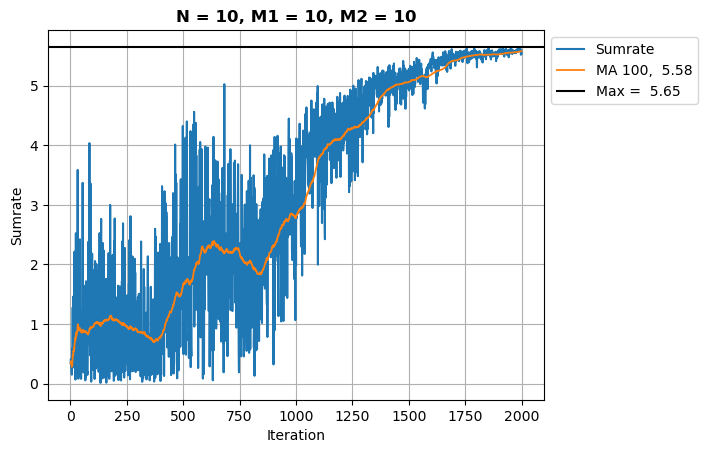

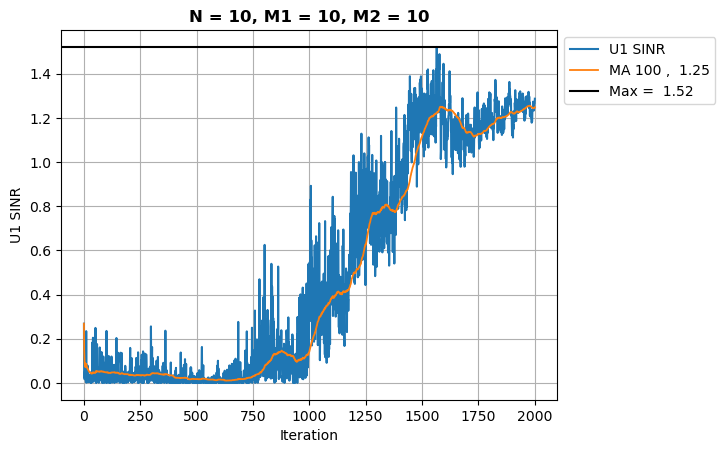

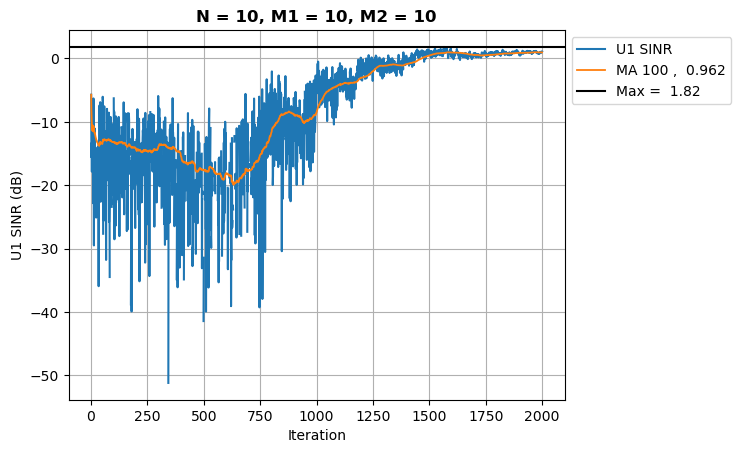

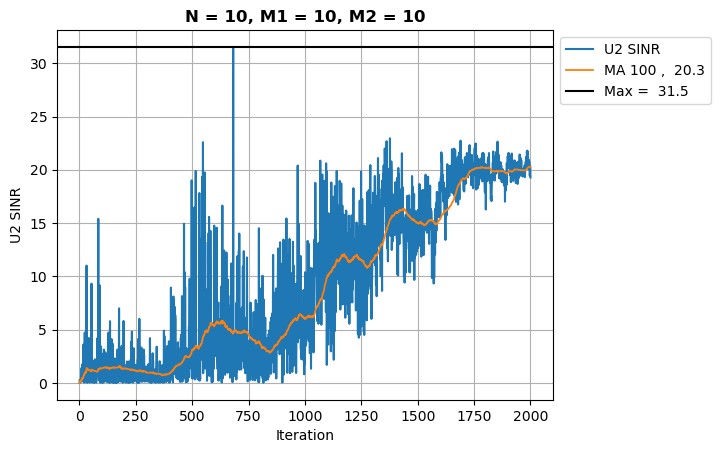

/home/danesh/Desktop/IRS-Project/src/plot.py:183: RuntimeWarning: divide by zero encountered in log10
  plt.plot(range(1, len(moving_average) + 1), 10 * np.log10(moving_average),


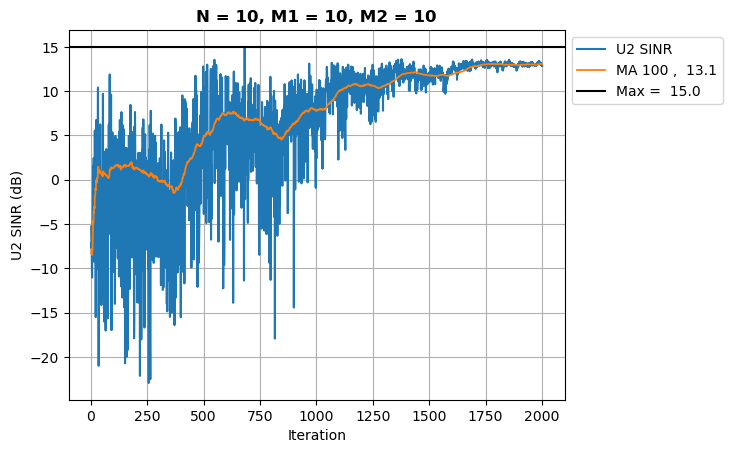

In [17]:
sigma = 1e-2
env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
              path_loss_exponent=2, irs1_to_antenna=20,
              irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
              state_dB=False, without_irs=False, double_reflection=True, no_irs=False)

U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=True,
                            los_to_irs2=False, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1, data = run2(2000, variable_noise=True, env=env, isplot=True, alpha=0.0002,
                            beta=0.0004, batch_size=128, multi_actor=True, last_layer_activation="tanh", buffer_size=500,
                            num_of_actors=4,)



In [42]:
import matplotlib.pyplot as plt
num_of_runs = 5
sigma = 1e-2
irs1_elements = [5, 10, 20, 30, 40, 50]

final_sumrates = np.zeros((len(irs1_elements),))
final_u1_rates = np.zeros((len(irs1_elements),))
final_u2_rates = np.zeros((len(irs1_elements),))

for indx, elemnt_num in enumerate(irs1_elements):
       sumrates = np.zeros((num_of_runs,))
       u1_rates = np.zeros((num_of_runs,))
       u2_rates = np.zeros((num_of_runs,))


       for _ in range(num_of_runs):
       
              env = Environment(num_of_antennas=10, num_of_irs1=elemnt_num, num_of_irs2=10,
              path_loss_exponent=2, irs1_to_antenna=20,
              irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1, reward_function="man6",
              state_dB=False, without_irs=True, double_reflection=True, no_irs=True)

              U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)

              U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                                          noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                                          los_to_irs2=True, sinr_threshold=1, penalty=10, allocated_power=0.5, weight=1)


              agent1, last_sumrate1, last_u1_sinr1, last_u2_sinr1 = run2(2000, variable_noise=True, env=env, isplot=False, alpha=0.0002,
                                          beta=0.0004, batch_size=128, multi_actor=True, last_layer_activation="tanh", buffer_size=500,
                                          num_of_actors=4,)
              
              
              

              sumrates[_] = last_sumrate1
              u1_rates[_] = np.log2(1+last_u1_sinr1)
              u2_rates[_] = np.log2(1+last_u2_sinr1)


              print(f"Iter:{_ + 1 : < 5} Sumrate = {last_sumrate1: < 10.3} U1_Rate_1 = {np.log2(1+last_u1_sinr1): < 10.3}\
       U2_Rate_1 = {np.log2(1+last_u2_sinr1) : < 10.3}")     


       final_sumrates[indx] = sumrates.max()
       final_u1_rates[indx] = u1_rates.max()
       final_u2_rates[indx] = u2_rates.max()



       print(f"Sumrate_1 = {final_sumrates[indx] : < 10.3} U1_Rate_1 = {final_u1_rates[indx]: < 10.3}\
       U2_Rate_1 = {final_u2_rates[indx] : < 10.3}")     
       print("\n")
      

plt.plot(irs1_elements, final_sumrates, label="Sumrate", linewidth=2)
plt.ylabel("Sumrate")
plt.xlabel("Number of IRS1 Elements")
plt.title("Sumrate vs Number of IRS1 Elements")
plt.grid(1)
plt.show()

fig , ax = plt.subplots(2,1)
ax[0].plot(irs1_elements, final_u1_rates, label="U1 Rate", linewidth=2)
ax[0].set_ylabel("U1 Rate")
ax[0].set_xlabel("Number of IRS1 Elements")
ax[0].grid(1)

ax[1].plot(irs1_elements, final_u2_rates, label="U2 Rate", linewidth=2)
ax[1].set_ylabel("U2 Rate")
ax[1].set_xlabel("Number of IRS1 Elements")
ax[1].grid(1)




Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.67it/s]


Iter: 1    Sumrate =  7.44      U1_Rate_1 =  3.96            U2_Rate_1 =  3.48     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.35it/s]


Iter: 2    Sumrate =  6.98      U1_Rate_1 =  3.86            U2_Rate_1 =  3.12     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.10it/s]


Iter: 3    Sumrate =  7.81      U1_Rate_1 =  4.2             U2_Rate_1 =  3.61     


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 28.02it/s]


Iter: 4    Sumrate =  1.21      U1_Rate_1 =  0.486           U2_Rate_1 =  0.723    


Agent is Learning 😀 : 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.40it/s]


Iter: 5    Sumrate =  5.02      U1_Rate_1 =  2.32            U2_Rate_1 =  2.7      
Sumrate_1 =  7.81      U1_Rate_1 =  4.2             U2_Rate_1 =  3.61     




Agent is Learning 😀 :   6%|███▊                                                        | 127/2000 [00:05<01:22, 22.77it/s]


KeyboardInterrupt: 